## 1. 소개

- league of legends 경기 대회 관련 데이터입니다. 
- LCK, NALCS, EULCS, LMS, CBLoL, World Championship, Mid-Season invitational tournaments 대회가 포함되어 있습니다. 
- kaggle의 데이터를 활용하여 Kernels에 올라온 분석한 내용을 코드 및 데이터를 보는 관점 등을 파악하며 공부하기 위해 만들었습니다. 
- 원본 : https://www.kaggle.io/svf/1088701/7b76f31209fc5a40c70af9ddd14b16c6/__results__.html#introduction

In [133]:
options(jupyter.plot_mimetypes = 'image/png')
knitr::opts_chunk$set(out.width='1000px',dpi=200,message=FALSE,warning=FALSE)

In [102]:
install.packages('gridExtra', repos='http://cran.us.r-project.org')

Warning message:
"package 'gridExtra' is in use and will not be installed"

In [103]:
install.packages('matrixStats', repos='http://cran.us.r-project.org')

Warning message:
"package 'matrixStats' is in use and will not be installed"

In [104]:
library(ggplot2)
library(dplyr)
library(gridExtra)
library(grid)
library(matrixStats)
library(RColorBrewer)

## 2. 데이터 파일
- banValues.csv : 챔피언 밴 순서
- deathValues.csv : 모든 죽음에 대한 보조인 time, victim, killer
- goldValues.csv : 모든 팀과 플레이어의 분당 gold 값
- LeagueofLegends.csv :  League, Season, Year, Team Names, Results, Game Length, Player Names, Champion Names
- objValues.csv : Objective 유형 및 시간

LeagueofLegends.csv 에는 주어진 게임에 대한 모든 정보가 포함되어 있고, 나머지 파일은 게임(행)에 대한 정보/ 세부정보(열) 이 있습니다.

## 3. 일반적인 그래프

In [105]:
global <- read.csv('data//LeagueofLegends.csv', sep=',')
any(is.na(global))

[1] FALSE

## 3.1 일부 정의
- CBLOL : Cricutio Brasileio de Legends of Legends는 전문 Brazilian 팀을 특징으로 하는 토너먼트
- Europe : Legends Championship Series (EU LCS) 리그 1위(유럽 베를린)
- LCK : 리그 오브 레전드 챔피언스 리그(LCK) 1위(한국)
- LMS : 리그 오브 레전드 마스터 시리즈 1위(타이페이)
- Mid-Season_Invitational : Riot Games가 현재 리그 시즌의 봄과 여름 경기를 주최하는 토너먼트
- North_America : 리그 오브 레전드 챔피언십 시리즈(NA LCS) 1위(북미)
- Season_World_Championship : Legends World Championship은 Riot Games가 매년 주최하는 연례 세계 챔피언십 토너먼트

## 3.2 리그 및 연당 게임 수

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

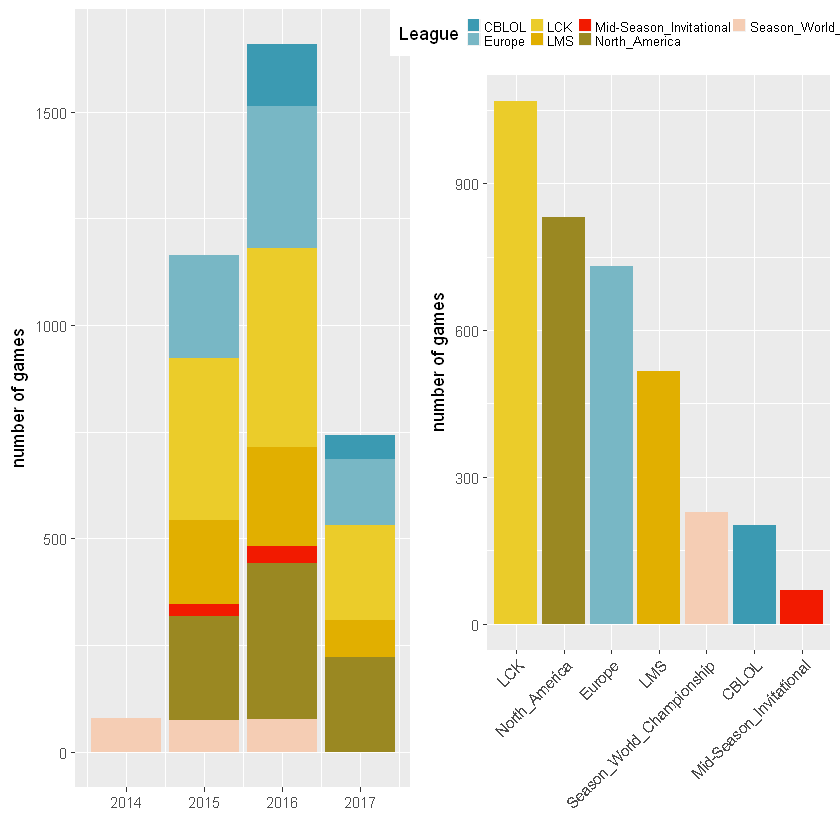

In [106]:
g1<-global %>% 
  group_by(League, Season, Year) %>% summarise(number=n()) %>% # 연당 league, season 별 count
  ggplot(aes(x=Year,y=number,fill=League)) + 
  geom_histogram(stat='identity',position='stack') + # stack 형식으로 쌓기
  scale_fill_manual(values=c("#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00","#9A8822", "#F5CDB4", "#F8AFA8")) + 
  theme(legend.position='none')  + xlab('') + ylab('number of games')

g2<-global %>% 
  group_by(League) %>% summarise(number=n()) %>% # league 별 count
  ggplot(aes(x=reorder(League,-number),y=number,fill=League)) + 
  geom_histogram(stat='identity') + 
  scale_fill_manual(values=c("#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00","#9A8822", "#F5CDB4", "#F8AFA8")) + 
  theme(legend.position='top',axis.text.x = element_text(angle=45, hjust=1),legend.text=element_text(size=8),legend.key.size = unit(.3, "cm"))  + xlab('') + ylab('number of games')

grid.arrange(g1,g2,ncol=2)

이 dataset에서는 LCK League에서 가장 많은 게임이 나온걸 알 수 있음

## 3.3 시즌 당 게임 수, 리그와 연도별 breakdown 

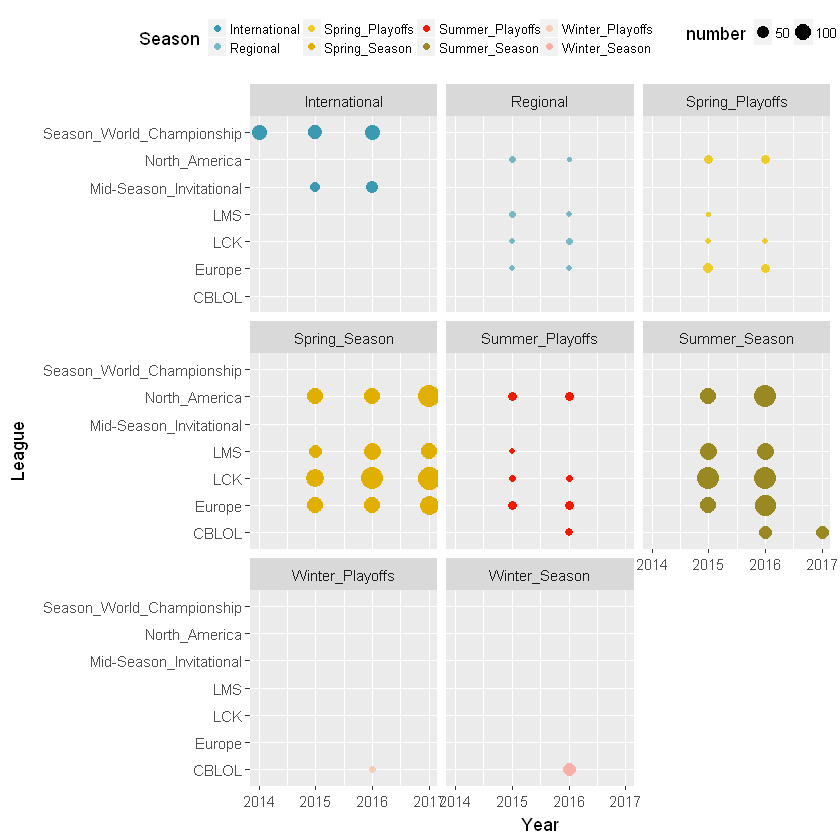

In [107]:
global %>% 
  group_by(League,Season,Year) %>% summarise(number=n()) %>% 
  ggplot(aes(x=Year,y=League, size=number,color=Season)) + 
  geom_point() + facet_wrap(~Season) + 
  theme(legend.position="top",legend.text=element_text(size=8),legend.key.size = unit(.4, "cm")) + 
  scale_color_manual(values=c("#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00","#9A8822", "#F5CDB4", "#F8AFA8"))

- Winter_Playoffs와 Winter_Season에는 CBLOL 리그만 진행됨.
- Spring 과 Summer_Season에 많은 리그가 진행됨.

## 3.4 게임 평균 시간(리그당)

ERROR: Error: Don't know how to add RHS to a theme object


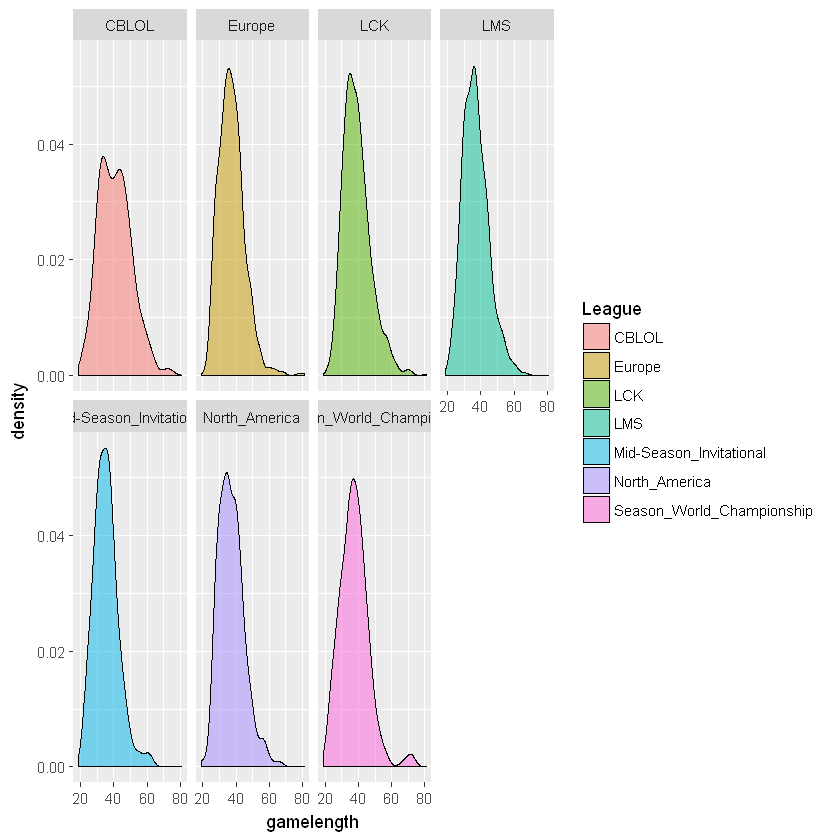

In [108]:
global %>%
dplyr::select(League, Season, gamelength) %>%
group_by(League) %>%
ggplot(aes(x=gamelength))+
geom_density(aes(fill=League), alpha=.5)+
facet_wrap(~League, ncol=4)
theme(legend.position='top')+
scale_fill_manual(values=c("#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00","#9A8822", "#F5CDB4", "#F8AFA8"))+xlab('[minutes]')+ylab('')

Season_World_Championship 의 경우 대회 기간동안 게임 시간이 가장 타이트 한 것을 알 수 있다.

## 3.5 Blue/Red 팀별 승수

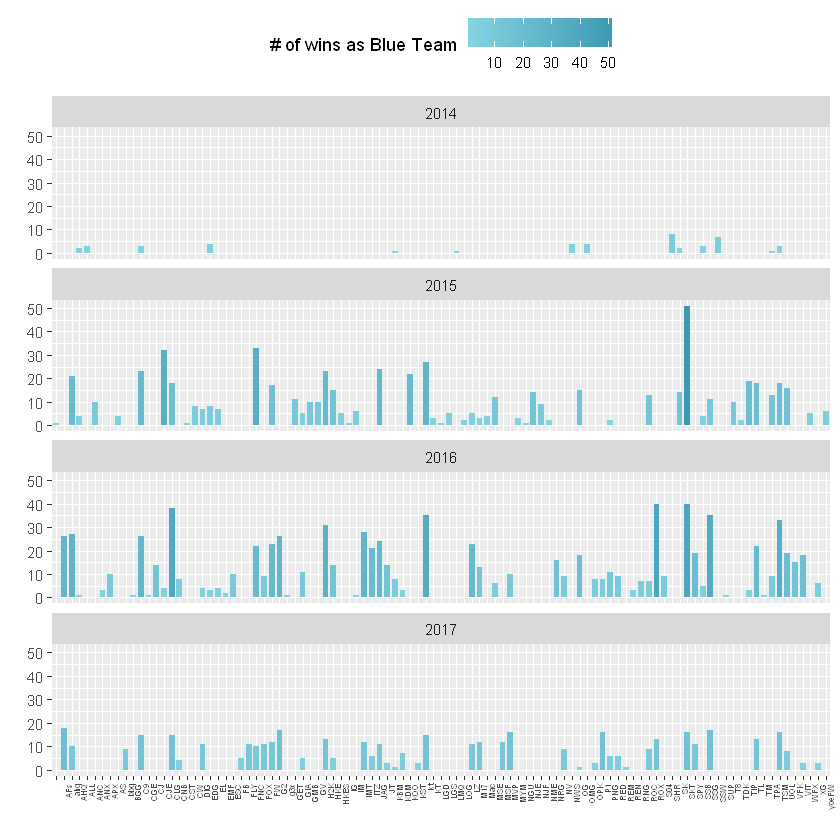

In [109]:
global %>%
dplyr::select(blueTeamTag, bResult, Year) %>%
dplyr::filter(bResult==1) %>%
dplyr::group_by(blueTeamTag, Year) %>%
summarise(number=n()) %>%
ggplot(aes(x=blueTeamTag, y=number, fill=number))+
geom_bar(stat='identity', width=.75)+
theme(legend.position='top', axis.text.x = element_text(angle=90, hjust=1, size=5))+
facet_wrap(~Year, ncol=1)+
xlab('')+ylab('')+scale_fill_gradient(name='# of wins as Blue Team', low='#85D4E3', high='#3B9AB2')

한국에서 상위권에 속하는 팀들이 blue 팀에서 승리한 경우가 많다.(게임수 때문인지, 진짜인지는 봐야할 듯 하다.)

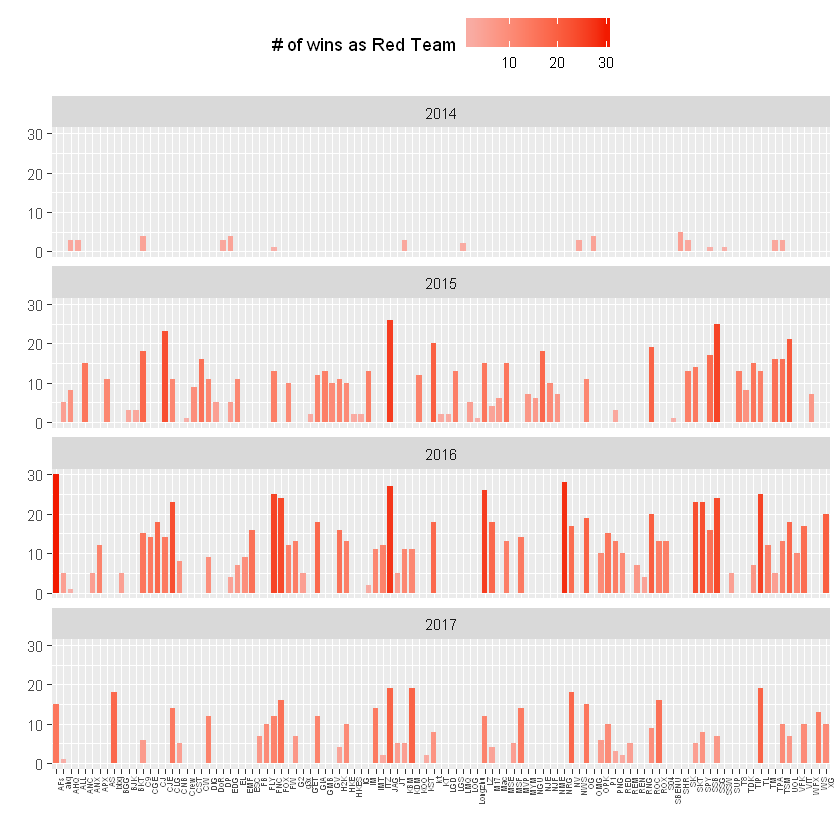

In [110]:
global %>%
dplyr::select(redTeamTag, bResult, Year) %>%
dplyr::filter(bResult==1) %>%
dplyr::group_by(redTeamTag, Year) %>%
summarise(number=n()) %>%
ggplot(aes(x=redTeamTag, y=number, fill=number))+
geom_bar(stat='identity', width=.75)+
theme(legend.position='top', axis.text.x = element_text(angle=90, hjust=1, size=5))+
facet_wrap(~Year, ncol=1)+xlab('') + ylab('') + scale_fill_gradient(name='# of wins as Red Team',low="#F8AFA8", high="#F21A00")

regTeam의 경우 한국팀 뿐만 아니라 외국의 팀들 중에도 red 팀에서 이긴 경우가 blue 팀보다 많은 것으로 보인다.

## 4. 경기 상세

### 4.1.1 팀당 골드 차이

골드 차이 = 블루팀 골드 - 레드팀 골드

- 게임을 선택하고 분을 row로 하도록 데이터를 변환한다.
- 블루팀과 레드팀의 결과를 얻기 위해 데이터 셋을 전체 데이터셋과 병합한다
- 분 컬럼을 추가한다
- 게임 결과 컬럼을 추가한다
- 그래프 : gold의 차이가 양수이면 블루팀이 많이 가진 것으로 생각해서 팀색깔로 그래프를 표시

In [111]:
gold <- read.csv('data/goldValues.csv', sep=",")
death <- read.csv('data/deathValues.csv', sep=",")
objects <- read.csv('data/objValues.csv', sep=",")
bans <- read.csv('data/banValues.csv', sep=",")

In [112]:
game_id <- 1

In [113]:
game1<-data.frame(t(gold[game_id,3:83]))
colnames(game1)<-'gold_diff'
features<-rownames(game1)
rownames(game1)<-1:nrow(game1)
game1$time<-rep(1:nrow(game1))
game1$MatchHistory<-rep(global$MatchHistory[1],nrow(game1))
res<-data.frame(merge(game1, global %>% select(MatchHistory,League,Season,Year,blueTeamTag,bResult, redTeamTag,rResult,gamelength),by='MatchHistory',y.all=T))
res$blueTeam<-ifelse(res$bResult==1,"BLUE:W ; RED:L","BLUE:L ; RED:W")

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

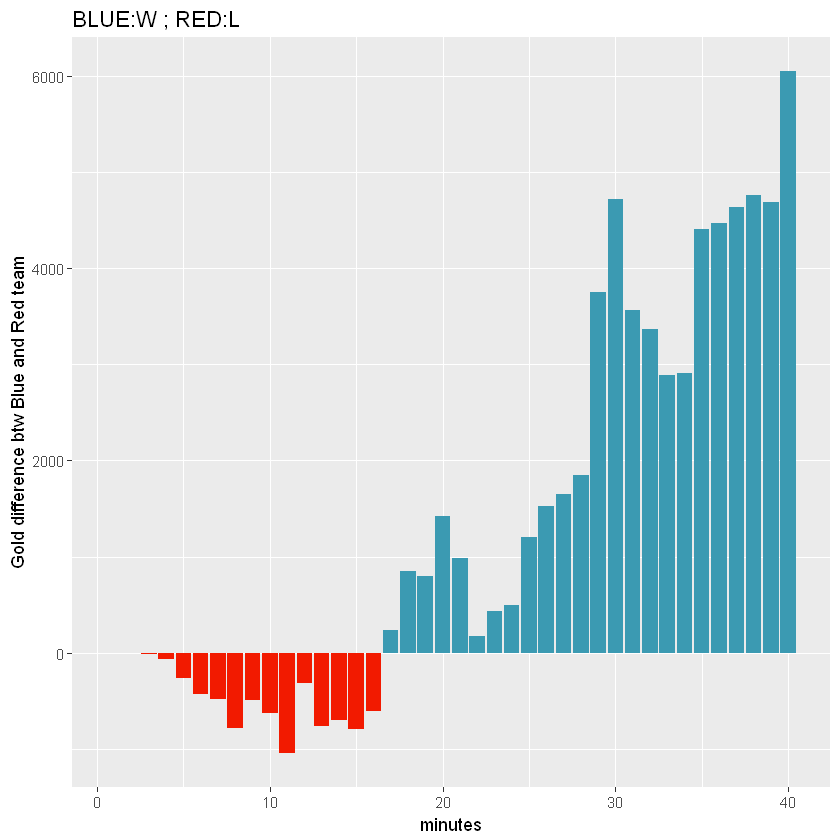

In [114]:
res %>% na.omit() %>% 
  ggplot(aes(x=time,y=gold_diff,shape=blueTeam,fill=ifelse(gold_diff>0,"blue","red"))) + 
  geom_histogram(stat='identity',size=1) + 
  scale_fill_manual(name="Team",values=c(blue="#3B9AB2",red="#F21A00")) + 
  scale_shape_manual(name='Result',values = c(19)) + 
  theme(legend.position='none') + ggtitle(res$blueTeam) + 
  xlab('minutes') + ylab('Gold difference btw Blue and Red team')

### 4.1.2 팀 플레이 킬수

- blue 팀에서 red팀을 킬한 경우 +1 
- red 팀에서 blue팀을 죽이면 -1
- 또한 게임의 길이를 얻기 위해 데이터셋을 전체 데이터셋에 합침

In [115]:
# 특정 게임id에 대해 데이터 뽑기
gameIndex <- global$MatchHistory[game_id]
resD <- death %>% 
  filter(MatchHistory==global$MatchHistory[game_id]) %>% 
  merge(global %>% select(MatchHistory,League,Season,Year,blueTeamTag,bResult,redTeamTag,rResult,gamelength),by='MatchHistory',y.all=T)

In [116]:
nrow(resD)

[1] 25

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"position_stack requires non-overlapping x intervals"Warning message:
"position_stack requires non-overlapping x intervals"

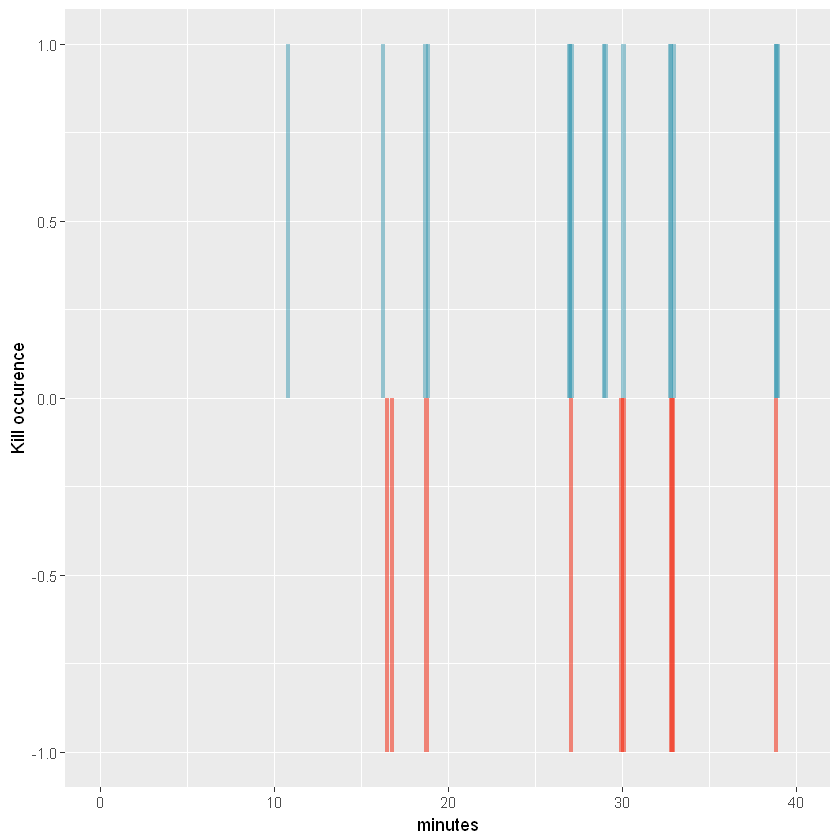

In [117]:
ggplot(data=resD,aes(x=Time,y=ifelse(TeamColor=='Blue',1,-1),fill=ifelse(TeamColor=='Blue','blue','red'))) + 
  geom_histogram(stat='identity',width=.25,alpha=.5) +
  scale_fill_manual(name="Team",values=c(blue="#3B9AB2",red="#F21A00")) +
  xlab('minutes') + ylab('Kill occurence') +
  theme(legend.position='none') + xlim(0,resD$gamelength[1])

### 4.1.3 몬스터 킬(드래곤,타워,바론)

여기서 아이디어는 두 개의 별도 데이터 프레임 (파란색과 빨간색)을 만들고 다시 바인딩하는 것입니다. 별도로 파란색과 빨간색 레이블을 만들 수 있습니다.(skip - 데이터문제)

## 4.2 모든 데이터 확인

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"position_stack requires non-overlapping x intervals"Warning message:
"position_stack requires non-overlapping x intervals"

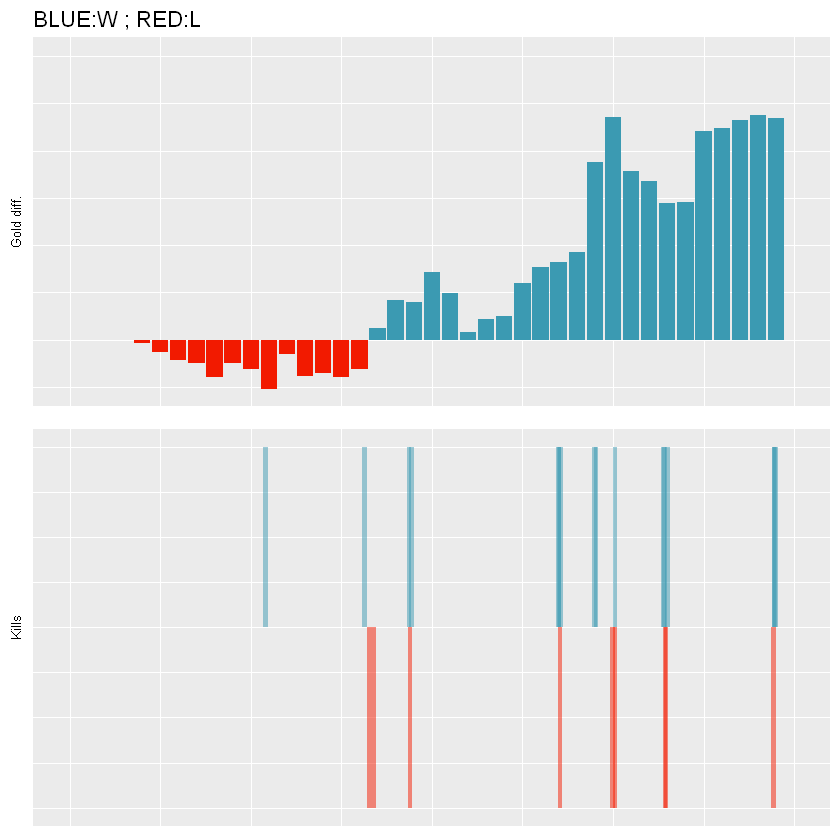

In [118]:
g1<-res %>% na.omit() %>% 
  ggplot(aes(x=time,y=gold_diff,shape=blueTeam,fill=ifelse(gold_diff>0,"blue","red"))) + 
  geom_histogram(stat='identity',size=1) + 
  scale_fill_manual(name="Team",values=c(blue="#3B9AB2",red="#F21A00")) + 
  scale_shape_manual(name='Result',values = c(19)) + ggtitle(res$blueTeam) + 
  theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank(),axis.title.y = element_text(size=8),axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.position='none') +  ylab('Gold diff.') + xlim(0,res$gamelength[1])

g2<-ggplot(data=resD,aes(x=Time,y=ifelse(TeamColor=='Blue',1,-1),fill=ifelse(TeamColor=='Blue','blue','red'))) + 
  geom_histogram(stat='identity',width=.25,alpha=.5) +
  scale_fill_manual(name="Team",values=c(blue="#3B9AB2",red="#F21A00")) +
  xlab('minutes') + ylab('Kills') +
  theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank(),axis.title.y = element_text(size=8),axis.text.y=element_blank(),axis.ticks.y=element_blank(),legend.position='none') + xlim(0,resD$gamelength[1])

grid.arrange(g1,g2, ncol=1)

## 5. 골드 vs 플레이 시간
- 승자/패자를 나누어 데이터 얻기
- MatchHistory로 결과를 goldValues 데이터셋과 병합
- 시간에 따라 최대 및 최소값을 계산
- 연도별 breakdown
- 오류 막대가 있는 그래프

In [119]:
getGold<- function(x) {
    # blue winners
    bW <- merge((global %>% filter(bResult == 1 & Year == x) %>% select(MatchHistory, gamelength, Season, Year, blueTeamTag, redTeamTag)), (gold %>% filter(NameType=='goldblue')) , by='MatchHistory')
    # red winners
    rW<-merge( (global %>% filter(rResult==1 & Year==x) %>% select(MatchHistory,gamelength,Season,Year,blueTeamTag,redTeamTag)),(gold %>% filter(NameType=='goldred')),by='MatchHistory')
    # dataset 합치기
    allWins <- data.frame(rbind(rW,bW))
    
    games_w <- data.frame(t(allWins[,8:83]))
    
    # 모든 게임의 평균,최대,최소 계산
    meanWG <- (games_w %>% select_if(is.numeric) %>% mutate(mean = rowMeans(.,na.rm=T)))$mean
    minWG <- rowMins(as.matrix(games_w), na.rm=T)
    maxWG <- rowMaxs(as.matrix(games_w), na.rm=T)
    
    # blue losers
    bL <- merge((global %>% filter(bResult == 0 & Year == x) %>% select(MatchHistory, gamelength, Season, Year, blueTeamTag, redTeamTag)),(gold %>% filter(NameType=='goldblue')), by='MatchHistory')
    rL <- merge((global %>% filter(rResult == 0 & Year == x) %>% select(MatchHistory, gamelength, Season, Year, blueTeamTag, redTeamTag)),(gold%>% filter(NameType=='goldred')), by='MatchHistory')
    
    allLoses <- data.frame(rbind(rL, bL))
    games_l <- data.frame(t(allLoses[,8:83]))
    
    meanLG <- (games_l %>% select_if(is.numeric) %>% mutate(mean = rowMeans(.,na.rm=T)))$mean
    minLG <- rowMins(as.matrix(games_l), na.rm=T)
    maxLG <- rowMaxs(as.matrix(games_l), na.rm=T)
    
    # 모든 데이터 합치기
    res <- as.data.frame(cbind(meanWG, minWG, maxWG, meanLG, minLG, maxLG))
    
    res$time <- rep(1:nrow(res))
    res$year <- rep(x,nrow(res))
    
    return(res)
}

gold_2014<-getGold(2014)
gold_2015<-getGold(2015)
gold_2016<-getGold(2016)
gold_2017<-getGold(2017)

In [120]:
res<-as.data.frame(rbind(gold_2014,gold_2015,gold_2016,gold_2017))

In [121]:
head(res)

,meanWG,minWG,maxWG,meanLG,minLG,maxLG,time,year
min_1,2424.744,2375,2455,2419.615,2375,2455,1,2014
min_2,2438.590,2375,3333,2421.500,2375,2468,2,2014
min_3,2822.449,2660,4858,2732.744,2660,3280,3,2014
min_4,3988.179,3377,5898,3874.282,3299,4432,4,2014
min_5,5304.064,4332,7717,5158.321,4429,6890,5,2014
min_6,6593.974,5527,8933,6405.782,5471,8212,6,2014


## 5.1 연도별 평균 골드

Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 4 rows containing missing values (geom_point)."

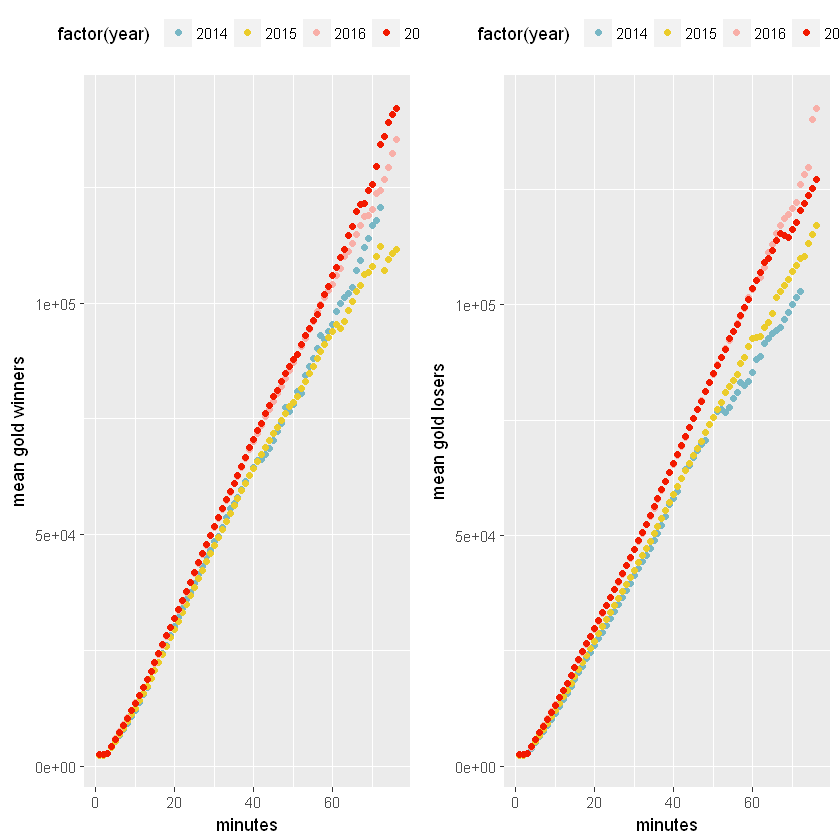

In [122]:
h1<-ggplot() + geom_point(data=res,aes(x=time,y=meanWG,color=factor(year))) +
  scale_color_manual(values=c("#78B7C5", "#EBCC2A", "#F8AFA8", "#F21A00")) + 
  xlab('minutes') + ylab('mean gold winners') + theme(legend.position='top')

h2<-ggplot() + geom_point(data=res,aes(x=time,y=meanLG,color=factor(year))) +
  scale_color_manual(values=c("#78B7C5", "#EBCC2A", "#F8AFA8", "#F21A00")) + 
  xlab('minutes') + ylab('mean gold losers') + theme(legend.position='top')
grid.arrange(h1,h2,ncol=2)

평균 골드 값이 2016,2017 / 2014,2015 각각 추세가 비슷하다고 볼수 있다.

### 5.2 연대비 평균 골드, breakdown by win/lose

Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 4 rows containing missing values (geom_point)."

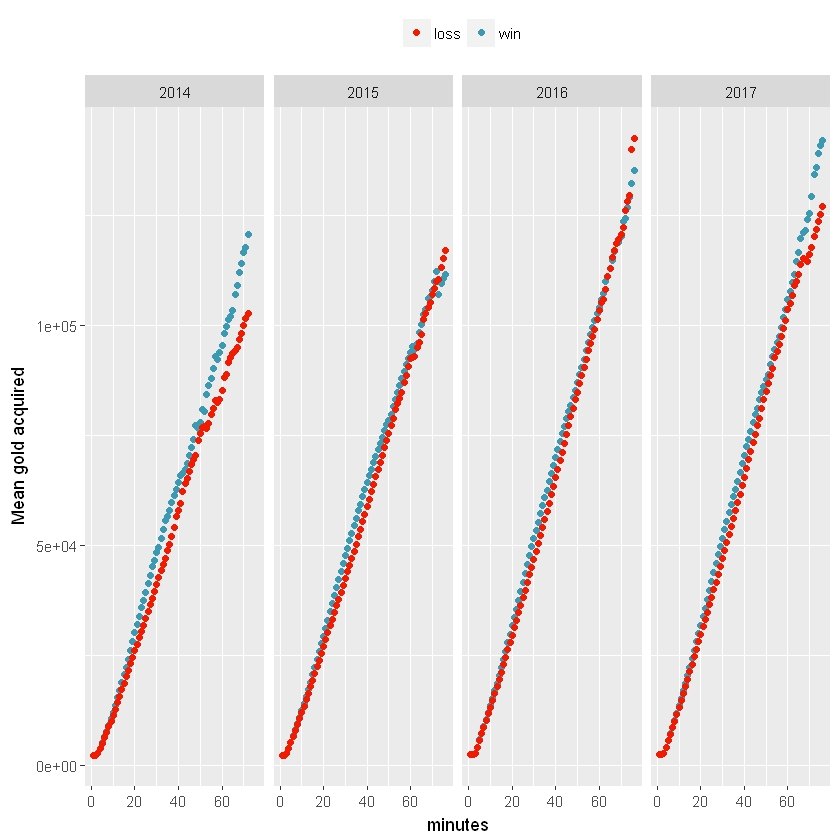

In [123]:
ggplot() + geom_point(data=res,aes(x=time,y=meanWG,color="win")) + geom_point(data=res,aes(x=time,y=meanLG,color="loss"))  +
  scale_color_manual(name="",values=c(win="#3B9AB2",loss="#F21A00")) + 
  xlab('minutes') + ylab('Mean gold acquired') + theme(legend.position='top') + facet_grid(~factor(res$year))

### 5.2.1 평균 골드 대비 연, breakdown by win/lose, with errors bars

In [124]:
list_plot<-list()
cnt<-1
for(i in 2014:2017){
  list_plot[[cnt]] <- ggplot() + 
    geom_errorbar(data=filter(res,year==i),aes(x=time,y=meanWG,ymin=minWG, ymax=maxWG),alpha=.5) + 
    geom_line() + geom_point(data=filter(res,year==i),aes(x=time,y=meanWG,color='win')) +
    scale_color_manual(name="",values=c(win="#3B9AB2")) + ggtitle(paste0('wins ; ',i)) +
    theme(legend.position='none') + ylab('')
  
  list_plot[[cnt+4]] <- ggplot() + 
    geom_errorbar(data=filter(res,year==i),aes(x=time,y=meanLG,ymin=minLG, ymax=maxLG),alpha=.5) + 
    geom_line() + geom_point(data=filter(res,year==i),aes(x=time,y=meanLG,color='loss')) +
    scale_color_manual(name="",values=c(loss="#F21A00")) + ggtitle(paste0('losses ;',i)) +
    theme(legend.position='none') + ylab('')
  
  cnt<-cnt + 1
}

Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"Warning message:
"Ignoring unknown aesthetics: y"

Warning message:
"Removed 4 rows containing missing values (geom_point)."Warning message:
"Removed 4 rows containing missing values (geom_point)."

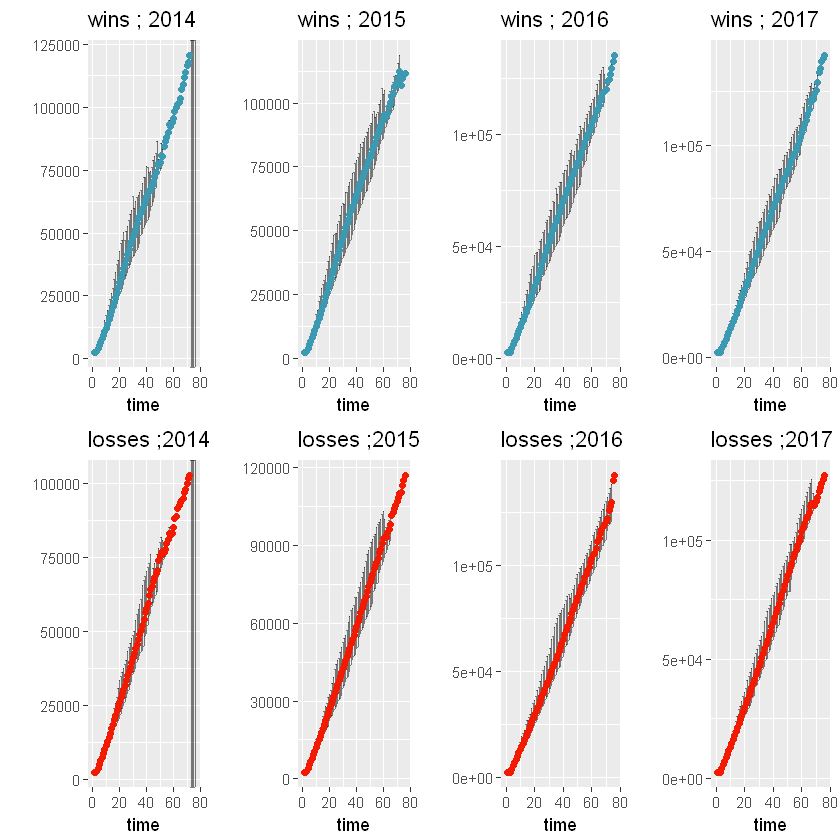

In [125]:
grid.arrange(list_plot[[1]],list_plot[[2]],list_plot[[3]],list_plot[[4]],
             list_plot[[5]],list_plot[[6]],list_plot[[7]],list_plot[[8]],ncol=4)

## 6. Ban 분석

In [126]:
head(bans)

MatchHistory,TeamColor,ban_1,ban_2,ban_3,ban_4,ban_5
http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30030?gameHash=fbb300951ad8327c,Blue,Rumble,Kassadin,Lissandra,,
http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30054?gameHash=055b17da8456fdc8,Blue,Kassadin,Sivir,Lissandra,,
http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30067?gameHash=8e8a9b58df366e2d,Blue,JarvanIV,Lissandra,Kassadin,,
http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30091?gameHash=0ed1cd0e0e57329c,Blue,Annie,Lissandra,Kassadin,,
http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30105?gameHash=f932becf86175f38,Blue,Irelia,Pantheon,Kassadin,,
http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30131?gameHash=194c672d7969984f,Blue,LeeSin,Rumble,Janna,,


In [127]:
# 팔레트
colfuncBlue <- colorRampPalette(c("black", "#3B9AB2"))
colfuncRed <- colorRampPalette(c("black", "#F21A00"))

In [128]:
colsBlue <- colfuncBlue(4)
colsRed <- colfuncRed(4)
bans[bans==""] <- NA

In [129]:
bans$numBans <- rowSums(!is.na(bans[-(1:2)]))
redBans <- data.frame(merge(global %>% select(MatchHistory, League, Season, Year, redTeamTag, rResult, gamelength), bans %>% filter(TeamColor=='Red') %>% select(MatchHistory, numBans), by='MatchHistory'))
redBans$RES <- ifelse(redBans$rResult == 0, 'LOSS', 'WIN')

In [130]:
blueBans <- data.frame(merge(global %>% select(MatchHistory, League, Season, Year, blueTeamTag, bResult, gamelength), bans %>% filter(TeamColor == 'Blue') %>% select(MatchHistory, numBans), by='MatchHistory'))
blueBans$RES <- ifelse(blueBans$bResult==0, 'LOSS', 'WIN')

In [131]:
rBans<-ggplot(data=redBans,aes(x=numBans,fill=factor(Year))) + geom_bar(position='dodge',width=.5) + scale_y_log10() + facet_grid(~factor(RES)) + scale_fill_manual(name="",values=colsRed) + xlab('number of bans') + theme(legend.position="right",axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())
bBans<-ggplot(data=blueBans,aes(x=numBans,fill=factor(Year))) + geom_bar(position='dodge',width=.5) + scale_y_log10() + facet_grid(~factor(RES)) + scale_fill_manual(name="",values=colsBlue) + xlab('number of bans') + theme(legend.position="right")

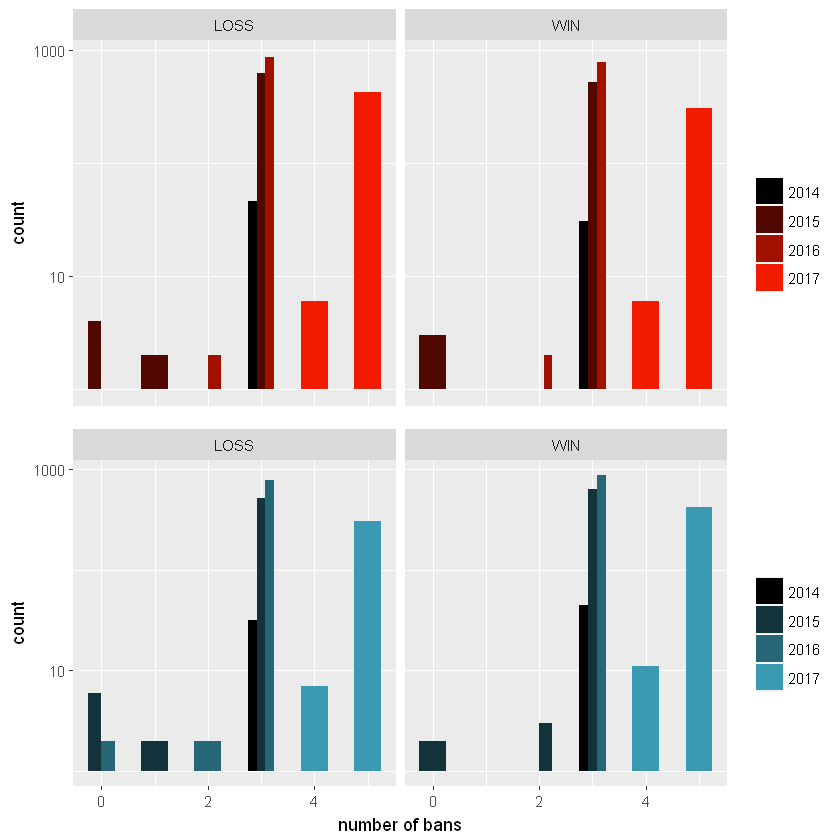

In [132]:
grid.arrange(rBans,bBans,ncol=1)

2017년에 밴 수가 3에서 5로 증가